In [1]:
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

def center_window_sum(a, snp, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(a[snp][start:end])
    return score

def calc_bis_score(a, win):
    #return max_sub_array_sum(a, size)
    win_sums = []
    for snp in range(len(a)):
        win_sum = center_window_sum(a, snp, win)
        win_sums.append(win_sum)
    return win_sums

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = calc_bis_score(snp_diffs[i], 11)
    # elementwise max among 3 lists
    max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals

('snp_orig shape=', (1000, 4), 10000)
('snp_diff 1 shape=', (1000, 4))
('snp_diff 2 shape=', (1000, 4))
('snp_diff 3 shape=', (1000, 4))


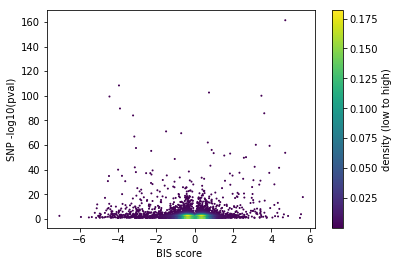

<Figure size 432x288 with 0 Axes>

In [4]:
#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
bis_scores = get_bis_scores(snp_diffs)



#snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
snp_dir  = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
#snp_file = "SPI1_10k.txt"
snp_file = "SPI1_under_peak_10k.txt"

snp_pvals = get_snp_pvals(snp_dir + snp_file)

#print(len(snp_pvals))
#print(len(bis_scores))

#%matplotlib inline
tf = 'SPI1'

%matplotlib inline
import matplotlib as mpl
#mpl.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)

x=bis_scores[:]
y=snp_pvals[:]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("BIS score ")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
plt.savefig("deeplift_score_vs_pval.png")    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

-----
scores/interpret.fa0
(10000, 1000, 4)
[[ 0.01104956  0.0475661   0.10883101 -0.05204432]
 [-0.02394702  0.16226488  0.04581844 -0.02952034]
 [-0.01951501  0.10879735  0.04759369 -0.04634675]
 [-0.0238685   0.16009252  0.10260912  0.01813819]
 [-0.09717034 -0.0001117   0.0719805   0.11220909]
 [ 0.02819489  0.09391585  0.23355442 -0.04708689]
 [-0.00967507  0.13762149  0.06260584  0.05664672]
 [-0.04272574 -0.08732188  0.23649459  0.03503941]
 [ 0.13926336  0.01155235  0.0840387  -0.09000225]
 [ 0.12658133 -0.11634417 -0.10683511  0.05151468]]
-----
SNP chr4:176935913 C->A
('tgaaaaaggg[c]agtgagaaa', 'importance score for original sequence')


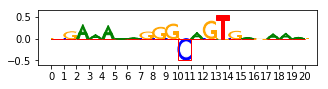

('TGAAAAAGGG[A]AGTGAGAAA', 'importance score for mutated sequence ')


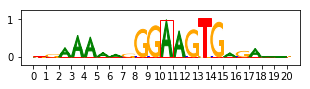

Mutation Impact Score 


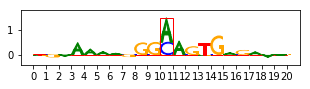

SNP chr12:16789835 C->T
('GTTTTCACTT[C]TGTTTTTCT', 'importance score for original sequence')


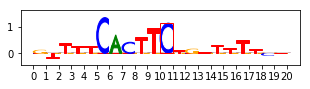

('GTTTTCACTT[T]TGTTTTTCT', 'importance score for mutated sequence ')


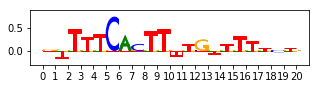

Mutation Impact Score 


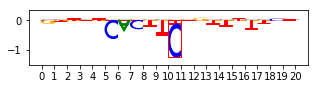

SNP chr12:8608502 T->A
('ACCCCACGTA[T]CGAAATCAC', 'importance score for original sequence')


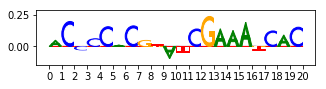

('ACCCCACGTA[A]CGAAATCAC', 'importance score for mutated sequence ')


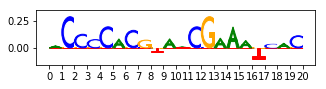

Mutation Impact Score 


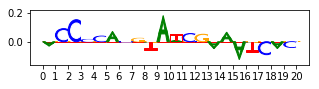

('max_mis_score=\n', [4.7196355, -3.9440002, 0.7456198, 3.4763813, -4.4394393])


In [5]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
snp_orig, orig_seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [0,2,0] # A->G(1), C->A(0), C->T(2)

snp_desc   = ["SNP chr4:176935913 C->A", "SNP chr12:16789835 C->T", "SNP chr12:8608502 T->A"]

def seqs_str(seqs, snp):
    return seqs[snp][490:500] + '[' + seqs[snp][500:501] + ']' + seqs[snp][501:510]

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
for snp in range(len(snp_desc)):
    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    print(snp_desc[snp])
    print(seqs_str(orig_seqs, snp), "importance score for original sequence")

    viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}

    for i in range(3): # each i is an allele
        snp_allele, seqs  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if i == allele_idx[snp]:
            print(seqs_str(seqs, snp), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
'''
for i in range(3):
    snp_diff = snp_diffs[i]
    print("allele", i)
    print(snp_diff[snp][499:502])

    win = 3
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(snp_diff[snp][start:end])
    print(start, end, score)
    
    win_sums = center_window_sum(snp_diff, snp, 3)
    print("winsums=", win_sums)
    bis_scores[i] = calc_bis_score(snp_diffs[i], 3)
    # elementwise max among 3 lists
    print("bis_scores for allele", i, bis_scores[i])

max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
print("max_bis_score=\n", max_bis_score[:5])
'''

max_bis_score = get_bis_scores(snp_diffs)
print("max_mis_score=\n", max_bis_score[:5])
